# Lecture 17: Artificial Neural Networks (ANN) II

MTU Spring 2024

Instructor: Abel Reyes

### Announcements

- HW6 grades on canvas
- Midterm grades on canvas
- Final course project guidelines on canvas.
- No Quiz this week
- HW7 deadlines is Wednesday 03/27/2024 by midnight

## Learning outcomes
- Explain the role of neural networks in machine learning, and the pros/cons of using them.
- Understand logistic regression as nn.
- No linealy separable function limitations with logistic regression
- Use of `keras`
- Explain why the methods we've learned previously would not be effective on image data.
- Apply pre-trained neural networks to classification and regression problems.


In [2]:
import mglearn

import glob
import copy
import os, sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import make_classification, make_moons, make_circles


from keras.optimizers import SGD


from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical

## Introduction to neural networks

- Very popular these days under the name **deep learning**. 
- Neural networks apply a sequence of transformations on your input data.
- They can be viewed a generalization of linear models where we apply a series of transformations. 
- Here is graphical representation of a logistic regression model. 
    - We have 4 features: x[0], x[1], x[2], x[3]

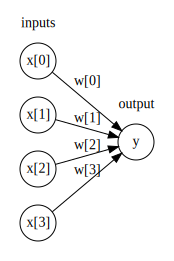

In [2]:

mglearn.plots.plot_logistic_regression_graph()

- Below we are adding one "layer" of transformations in between features and the target. 
- We are repeating the the process of computing the weighted sum multiple times.  
- The **hidden units** (e.g., h[1], h[2], ...) represent the intermediate processing steps. 

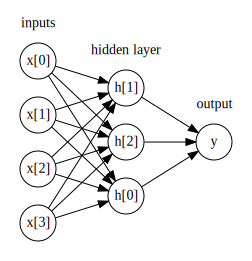

In [3]:
mglearn.plots.plot_single_hidden_layer_graph()

- Now we are adding one more layer of transformations. 

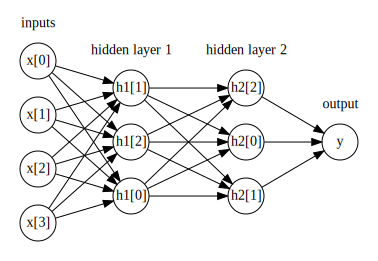

In [4]:
mglearn.plots.plot_two_hidden_layer_graph()

- At a very high level you can also think of them as `Pipelines` in `sklearn`. 
- A neural network is a model that's sort of like its own pipeline
  - It involves a series of transformations ("layers") internally. 
  - The output is the prediction.

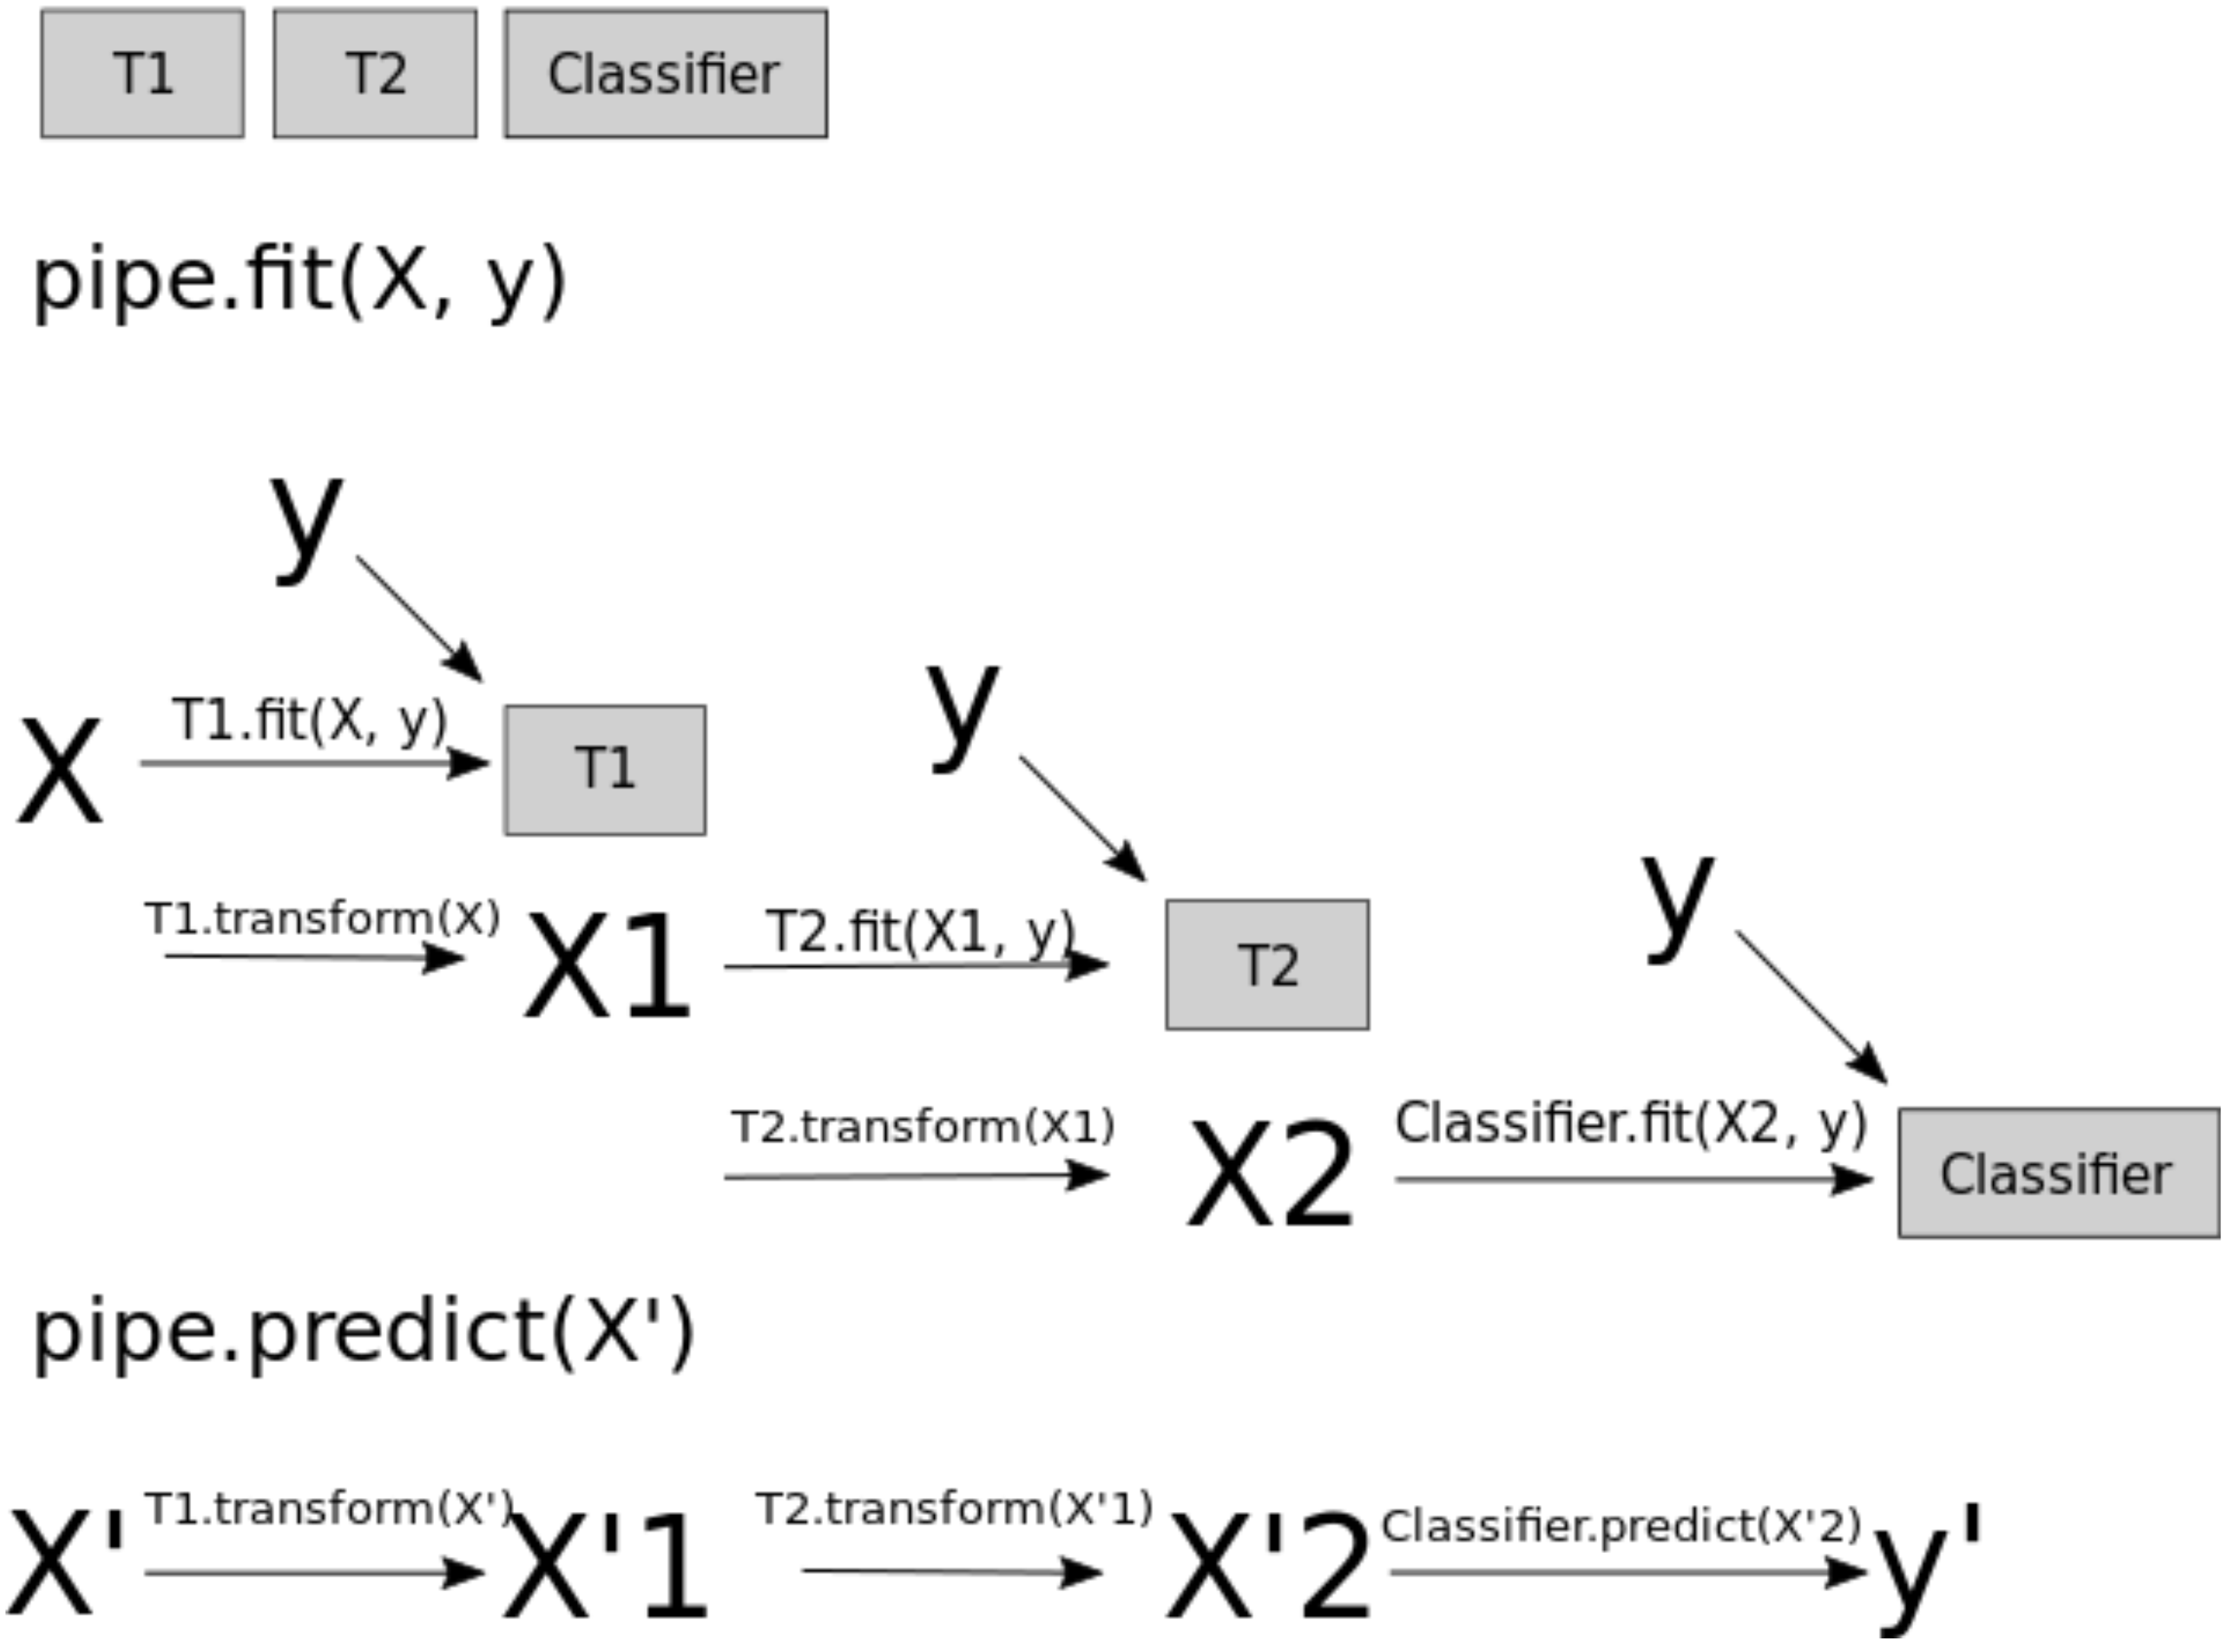

- Important question: how many features before/after transformation.
  - e.g. scaling doesn't change the number of features
  - OHE increases the number of features
- With a neural net, you specify the number of features after each transformation.
  - In the above, it goes from 4 to 3 to 3 to 1.

- To make them really powerful compared to the linear models, we apply a non-linear function to the weighted sum for each hidden node. 

### Terminology

- Neural network = neural net
- Deep learning ~ using neural networks

### Why neural networks?

- They can learn very complex functions.
  - The fundamental tradeoff is primarily controlled by the **number of layers** and **layer sizes**.
  - More layers / bigger layers --> more complex model.
  - You can generally get a model that will not underfit. 

### Why neural networks?

- The work really well for structured data:
  - 1D sequence, e.g. timeseries, language
  - 2D image
  - 3D image or video
- They've had some incredible successes in the last 10 years.
- Transfer learning (coming later today) is really useful.  

### Why not neural networks?

- Often they require a lot of data.
- They require a lot of compute time, and, to be faster, specialized hardware called [GPUs](https://en.wikipedia.org/wiki/Graphics_processing_unit).
- They have huge numbers of hyperparameters are a huge pain to tune.
  - Think of each layer having hyperparameters, plus some overall hyperparameters.
  - Being slow compounds this problem.
- They are not interpretable. (? not necesarely)

### Why not neural networks?

- When you call `fit`, you are not guaranteed to get the optimal.
  - There are now a bunch of hyperparameters specific to `fit`, rather than the model.
  - You never really know if `fit` was successful or not.
  - You never really know if you should have run `fit` for longer.
- I don't recommend training them on your own without further training
  - I'll show you some ways to use neural networks without calling `fit`.

### Deep learning software

- scikit-learn has [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) and [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) but they aren't very flexible.
  - In general you'll want to leave the scikit-learn ecosystem when using neural networks.
  - Fun fact: these classes were contributed to scikit-learn by a UBC graduate student.
- There's been a lot of deep learning software out there.

- The current big players are:

1. [PyTorch](http://pytorch.org)
2. [TensorFlow](https://www.tensorflow.org)

- Both are heavily used in industry.
- If interested, see [comparison of deep learning software](https://en.wikipedia.org/wiki/Comparison_of_deep_learning_software).

## One step back

### Limitations of linear models 

- Is your data "linearly separable"? Can you draw a hyperplane between these datapoints that separates them with 0 error. 
    - If the training examples can be separated by a linear decision rule, they are **linearly separable**.

A few questions you might be thinking about
- How often the real-life data is linearly separable?
- Is the following XOR function linearly separable?  

| $$x_1$$ | $$x_2$$ | target|
|---------|---------|---------|
| 0 | 0  | 0|
| 0 | 1  | 1|
| 1 | 0  | 1|
| 1 | 1  | 0|    

- Are linear classifiers very limiting because of this?     

In [5]:
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()
    
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

    
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_confusion_matrix(model, X, y):
    y_pred = model.predict(X, verbose=0)>0.5
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

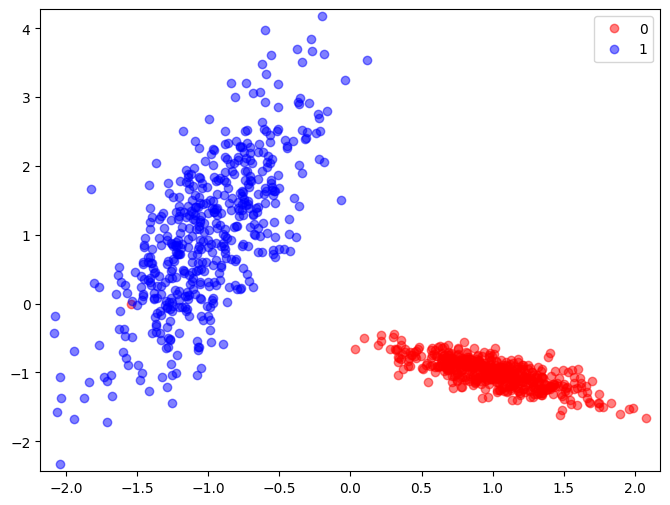

In [6]:
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, 
                           n_informative=2, random_state=7, n_clusters_per_class=1)
plot_data(X, y)

In [7]:
lr = LogisticRegression()
lr.fit(X, y)

LogisticRegression()

LR coefficients: [[-4.09049818  2.07274152]]
LR intercept: [-0.27800528]


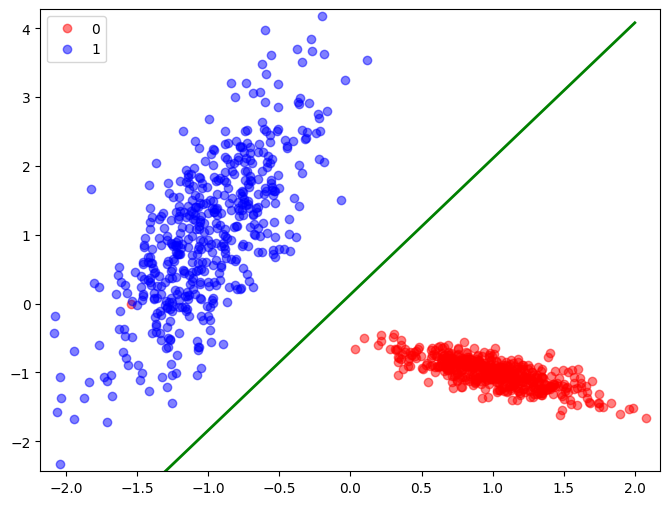

In [8]:
print('LR coefficients:', lr.coef_)
print('LR intercept:', lr.intercept_)

plot_data(X, y)

limits = np.array([-2, 2])
boundary = -(lr.coef_[0][0] * limits + lr.intercept_[0]) / lr.coef_[0][1]
plt.plot(limits, boundary, "g-", linewidth=2)

In [9]:

## Our first NN model
model = Sequential()
model.add(Dense(units=1, input_shape=(2,), activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x=X, y=y, verbose=1, epochs=75)


Epoch 1/75
32/32 [==============================] - 5s 3ms/step - loss: 1.7298 - accuracy: 0.0110
Epoch 2/75
32/32 [==============================] - 0s 3ms/step - loss: 1.6769 - accuracy: 0.0120
Epoch 3/75
32/32 [==============================] - 0s 3ms/step - loss: 1.6251 - accuracy: 0.0130
Epoch 4/75
32/32 [==============================] - 0s 3ms/step - loss: 1.5739 - accuracy: 0.0130
Epoch 5/75
32/32 [==============================] - 0s 3ms/step - loss: 1.5239 - accuracy: 0.0130
Epoch 6/75
32/32 [==============================] - 0s 3ms/step - loss: 1.4747 - accuracy: 0.0130
Epoch 7/75
32/32 [==============================] - 0s 3ms/step - loss: 1.4265 - accuracy: 0.0140
Epoch 8/75
32/32 [==============================] - 0s 3ms/step - loss: 1.3795 - accuracy: 0.0140
Epoch 9/75
32/32 [==============================] - 0s 3ms/step - loss: 1.3334 - accuracy: 0.0150
Epoch 10/75
32/32 [==============================] - 0s 3ms/step - loss: 1.2886 - accuracy: 0.0160
Epoch 11/75
32/32 [

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


<Figure size 800x600 with 0 Axes>

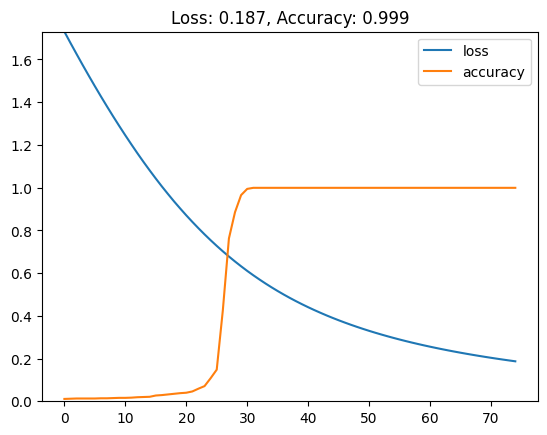

In [11]:
plot_loss_accuracy(history)

319/319 [==============================] - 0s 939us/step


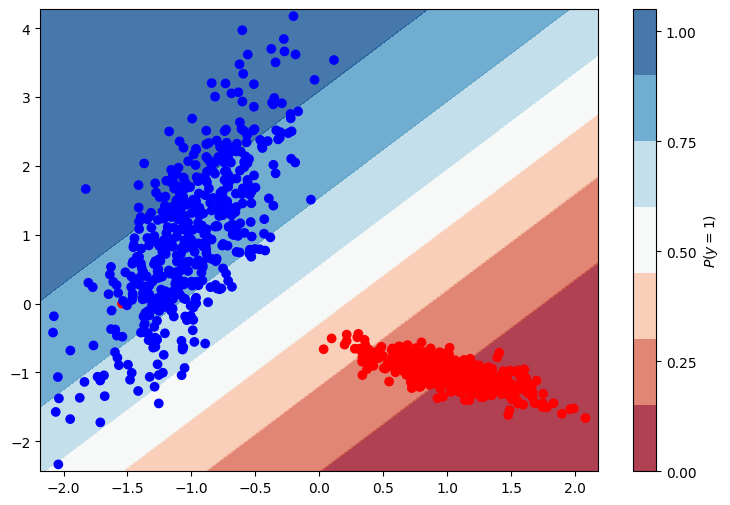

In [12]:
plot_decision_boundary(lambda x: model.predict(x), X, y)


In [13]:
y_pred = model.predict(X, verbose=0)>0.5

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       501
           1       1.00      1.00      1.00       499

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



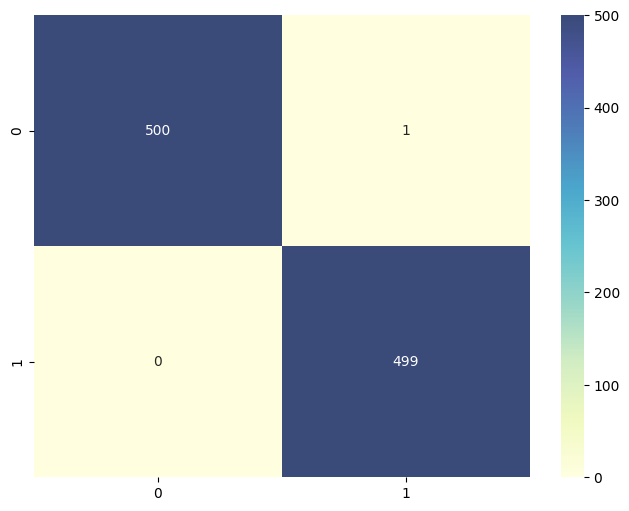

In [14]:
plot_confusion_matrix(model, X, y)


### Complex data - moons
The previous dataset was linearly separable, so it was trivial for our logistic regression model to separate the classes. Here is a more complex dataset which isn't linearly separable. The simple logistic regression model won't be able to distinguish between the classes.

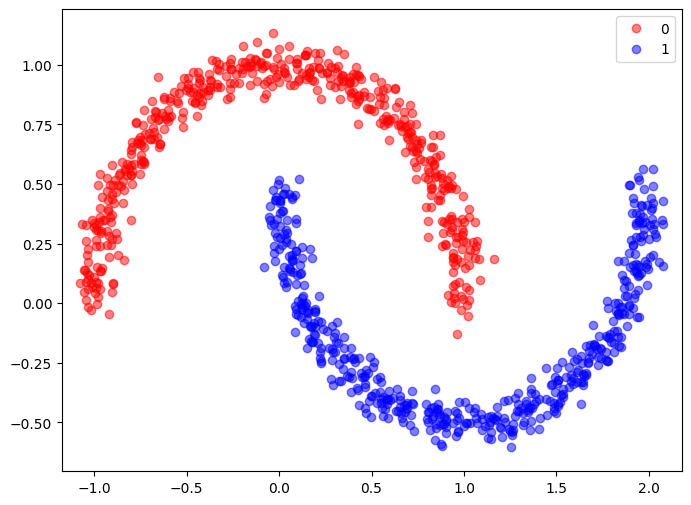

In [15]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)
plot_data(X, y)

We're building the another logistic regression model with the same parameters as we did before.



<Figure size 800x600 with 0 Axes>

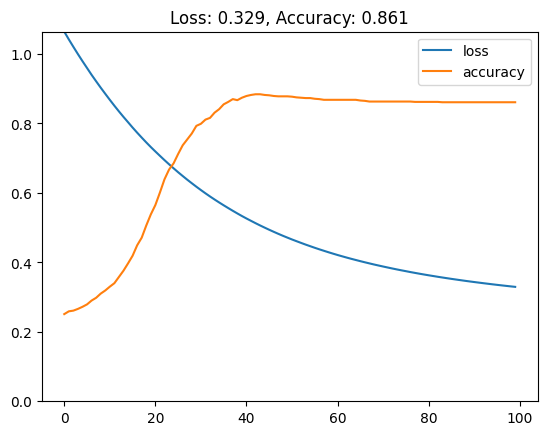

In [16]:
model = Sequential()
model.add(Dense(1, input_shape=(2,), activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=100)
plot_loss_accuracy(history)

319/319 [==============================] - 0s 928us/step


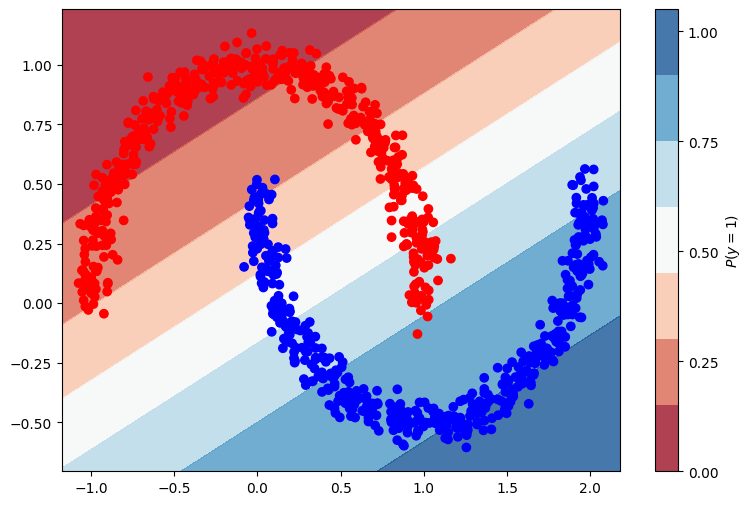

In [17]:
plot_decision_boundary(lambda x: model.predict(x), X, y)


Precision of the model is 86%. It looks good on paper but we should be able to get 100% with a more complex model. You can imagine a curved decision boundary that will separate out the classes, and a complex model should be able to approximate that.

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       500
           1       0.87      0.87      0.87       500

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



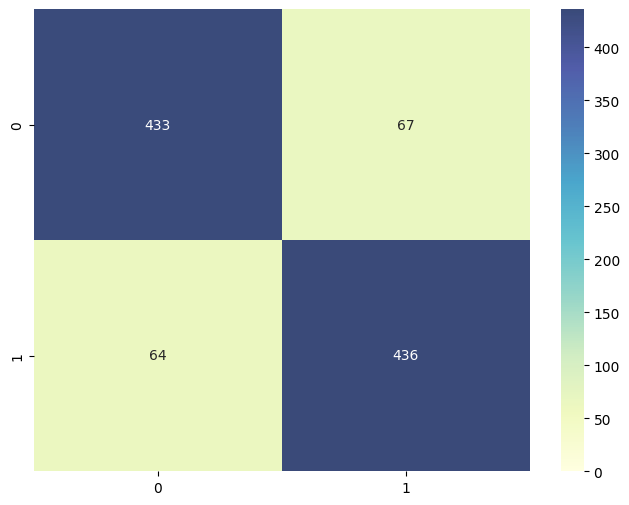

In [50]:
y_pred = model.predict(X, verbose=0)>0.5
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

### Complex Data - Circles
Let's look at one final example where the liner model will fail.

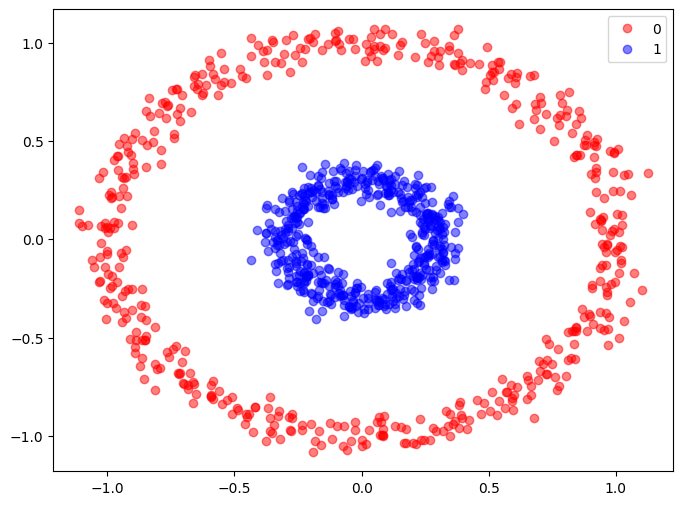

In [18]:
X, y = make_circles(n_samples=1000, noise=0.05, factor=0.3, random_state=0)
plot_data(X, y)

Building the model with same parameters.



<Figure size 800x600 with 0 Axes>

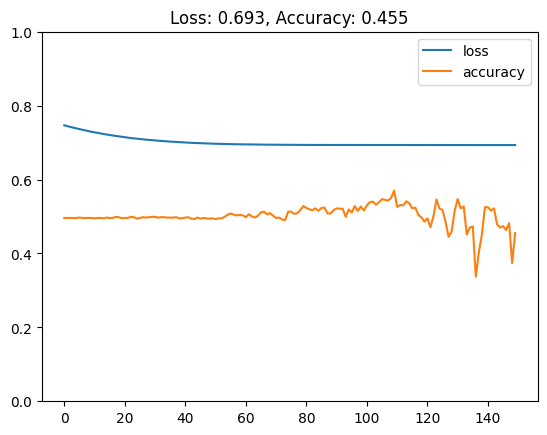

In [19]:
model = Sequential()
model.add(Dense(1, input_shape=(2,), activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=150)
plot_loss_accuracy(history)

The decision boundary again passes from the middle of the data, but now we have much more misclassified points.



319/319 [==============================] - 0s 890us/step


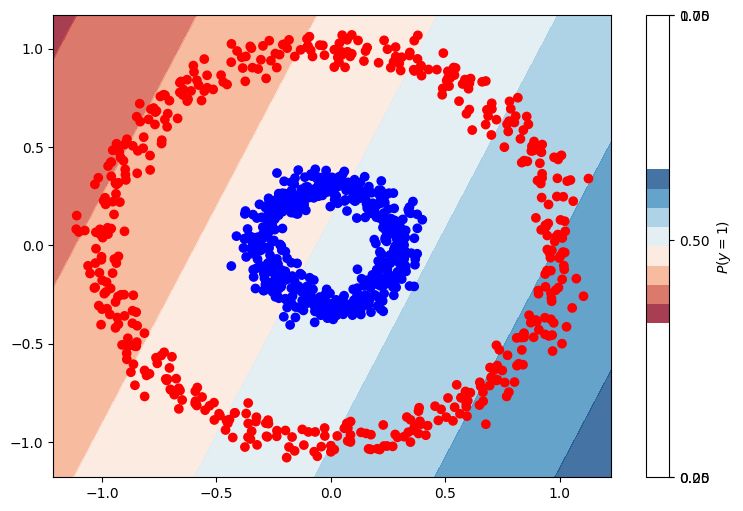

In [20]:
plot_decision_boundary(lambda x: model.predict(x), X, y)


The accuracy is 51%. No matter where the model draws the linear line, it will misclassify half of the points, due to the nature of the dataset.

The confusion matrix we see here is an example one belonging to a poor classifier. Ideally we want confusion matrices like the ones we saw above. High numbers along the diagonals meaning that the classifier was right, and low numbers everywhere else where the classifier was wrong. In our visualization, the color blue represents the high numbers and yellow represents the low ones. So we would prefer to see blue on the diagonals and yellow everywhere else, blues everywhere is a bad sign meaning that our classifier is confused.

              precision    recall  f1-score   support

           0       0.46      0.53      0.49       500
           1       0.45      0.39      0.42       500

    accuracy                           0.46      1000
   macro avg       0.46      0.46      0.46      1000
weighted avg       0.46      0.46      0.46      1000



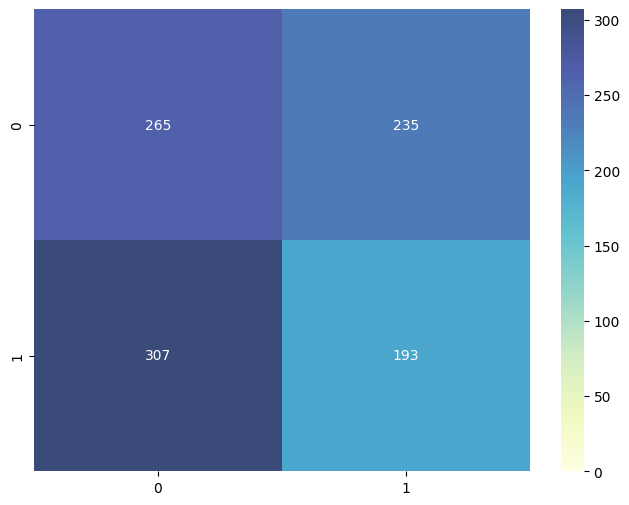

In [21]:
y_pred = model.predict(X, verbose=0)>0.5
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

## Artificial Neural Networks (ANN)
Now we will train a deep Artificial Neural Networks (ANN) to better classify the datasets which the logistic regression model struggled, Moons and Circles. 

While building Keras models for logistic regression above, we performed the following steps:

- Step 1: Define a Sequential model.
- Step 2: Add a Dense layer with sigmoid activation function. This was the only layer we needed.
- Step 3: Compile the model with an optimizer and loss function.
- Step 4: Fit the model to the dataset.
- Step 5: Analyze the results: plotting loss/accuracy curves, plotting the decision boundary, looking at the classification report, and understanding the confusion matrix.

While building a deep neural network, we only need to change step 2 such that, we will add several Dense layers one after another. The output of one layer becomes the input of the next. Keras again does most of the heavy lifting by initializing the weights and biases, and connecting the output of one layer to the input of the next. We only need to specify how many nodes we want in a given layer, and the activation function. It’s as simple as that.

Epoch 1/100


C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


32/32 [==============================] - 0s 4ms/step - loss: 0.5886 - accuracy: 0.6710
Epoch 2/100
32/32 [==============================] - 0s 4ms/step - loss: 0.4195 - accuracy: 0.8210
Epoch 3/100
32/32 [==============================] - 0s 4ms/step - loss: 0.3493 - accuracy: 0.8630
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3114 - accuracy: 0.8760
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2881 - accuracy: 0.8830
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2741 - accuracy: 0.8860
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2633 - accuracy: 0.8850
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2566 - accuracy: 0.8900
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2522 - accuracy: 0.8950
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2460 - accuracy: 0.8890
Epoch 11/100
32/32 [=

<Figure size 800x600 with 0 Axes>

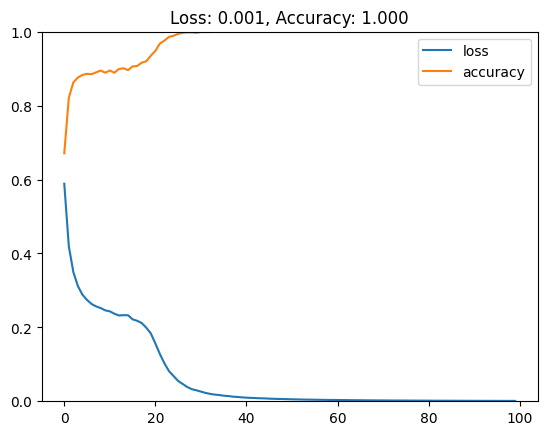

In [23]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)

model = Sequential()
model.add(Dense(4, input_shape=(2,), activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=1, epochs=100)

plot_loss_accuracy(history)

In [24]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 4)                 12        
                                                                 
 dense_7 (Dense)             (None, 2)                 10        
                                                                 
 dense_8 (Dense)             (None, 1)                 3         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


As you can see we first add a layer with 4 nodes and tanh activation function. Tanh is a commonly used activation function, and we'll learn more about it in another tutorial. We then add another layer with 2 nodes and again tanh activation. We finally add the last layer with 1 node and sigmoid activation. This is the final layer that we also used in the logistic regression model.

This is not a very deep ANN, it only has 3 layers: input layer, 1 hidden layer, and the output layer. But notice a couple of patterns:

Output layer still uses the sigmoid activation function since we're working on a binary classification problem.
Non-output layers use the tanh activation function. If we added more hidden layers, they would also have tanh activation.
We have fewer number of nodes in each subsequent layer. It's common to have less nodes as we stack layers on top of one another.
We didn't build a very deep ANN here because it wasn't necessary. We already achieve perfect accuracy with this configuration.

The ANN is able to come up with a perfect separator to distinguish the classes.



319/319 [==============================] - 0s 1ms/step


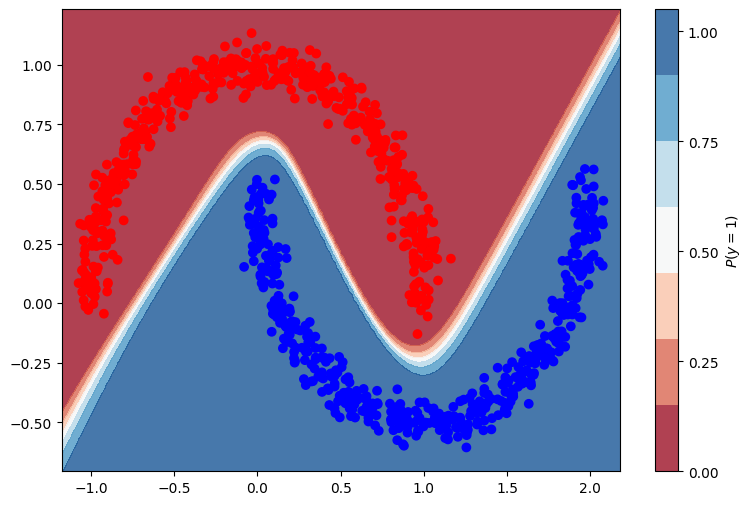

In [25]:
plot_decision_boundary(lambda x: model.predict(x), X, y)


100% precision, nothing misclassified.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



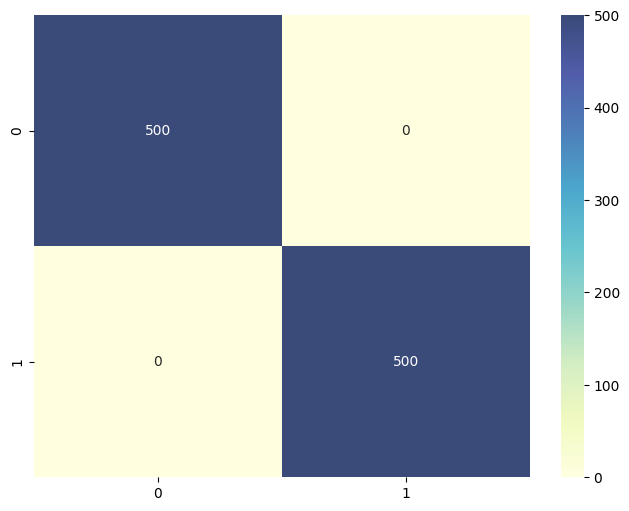

In [26]:
y_pred = model.predict(X, verbose=0)>0.5
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

### Complex Data - Circles

Now let's look at the Circles dataset, where the LR model achieved only 50% accuracy. The model is the same as above, we only change the input to the fit function. And we again achieve 100% accuracy.

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


<Figure size 800x600 with 0 Axes>

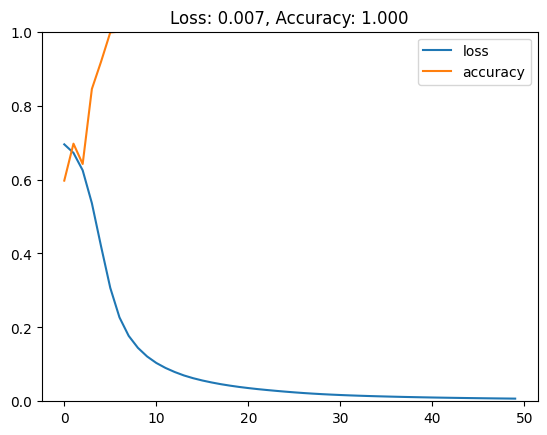

In [27]:
X, y = make_circles(n_samples=1000, noise=0.05, factor=0.3, random_state=0)

model = Sequential()
model.add(Dense(4, input_shape=(2,), activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=50)

plot_loss_accuracy(history)

Similarly the decision boundary looks just like one we would draw by hand ourselves. The ANN was able to figure out an optimal separator.

319/319 [==============================] - 0s 1ms/step


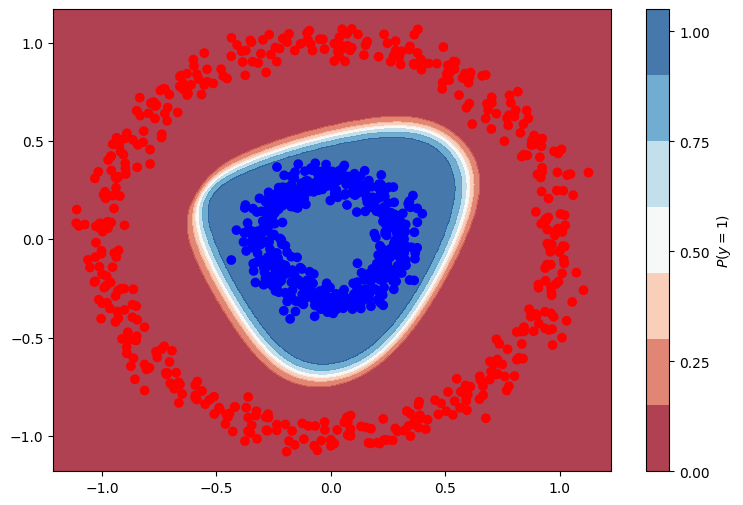

In [28]:
plot_decision_boundary(lambda x: model.predict(x), X, y)


Just like above we get 100% accuracy.



              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



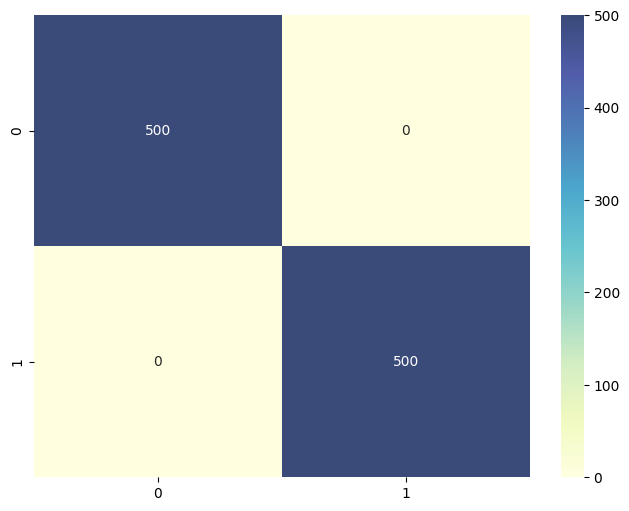

In [29]:
y_pred = model.predict(X, verbose=0)>0.5
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

## BTW, the XOR function as nn

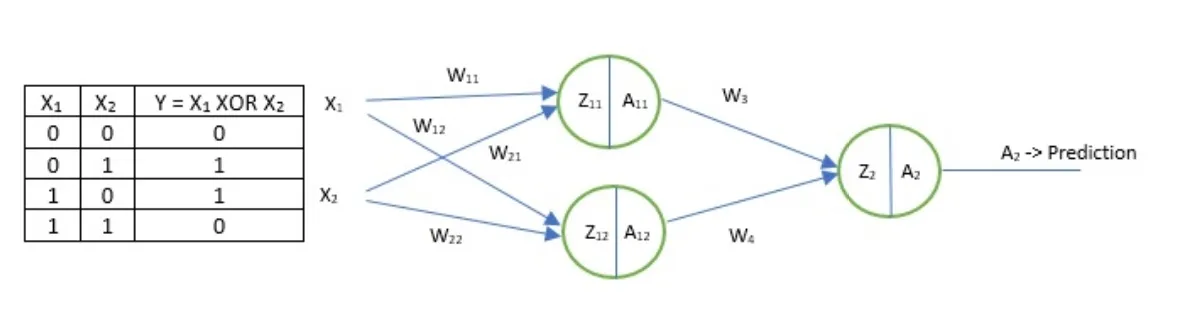

In [30]:
X = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([[0],[1],[1],[0]])

model = Sequential()
model.add(Dense(2, input_dim=2))
model.add(Activation('tanh'))##tanh
model.add(Dense(1))
model.add(Activation('sigmoid'))

sgd = SGD(lr=0.1)
model.compile(loss='binary_crossentropy', optimizer=sgd)

model.fit(X, y, batch_size=1, epochs=1000)


Epoch 1/1000


C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4/4 [==============================] - 0s 3ms/step - loss: 0.7161
Epoch 2/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.7153
Epoch 3/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.7145
Epoch 4/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.7138
Epoch 5/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.7140
Epoch 6/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.7135
Epoch 7/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.7133
Epoch 8/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.7126
Epoch 9/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.7123
Epoch 10/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.7124
Epoch 11/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.7117
Epoch 12/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.7120
Epoch 13/1000
4/4 [==============================] - 0s 2ms/st

4/4 [==============================] - 0s 2ms/step - loss: 0.5388
Epoch 205/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5356
Epoch 206/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5297
Epoch 207/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.5243
Epoch 208/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5198
Epoch 209/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.5153
Epoch 210/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5100
Epoch 211/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.5029
Epoch 212/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4982
Epoch 213/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4929
Epoch 214/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4860
Epoch 215/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4792
Epoch 216/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.0499
Epoch 407/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0496
Epoch 408/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0493
Epoch 409/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0491
Epoch 410/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0488
Epoch 411/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0485
Epoch 412/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0482
Epoch 413/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0480
Epoch 414/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0477
Epoch 415/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0474
Epoch 416/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0472
Epoch 417/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0469
Epoch 418/1000
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 0.0225
Epoch 609/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0225
Epoch 610/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0224
Epoch 611/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0223
Epoch 612/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0223
Epoch 613/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0222
Epoch 614/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0222
Epoch 615/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0221
Epoch 616/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0220
Epoch 617/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0220
Epoch 618/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0219
Epoch 619/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0219
Epoch 620/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 811/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 812/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 813/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 814/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 815/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 816/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 817/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 818/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 819/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 820/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 821/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 822/1000
4/4 [=======================

In [31]:
print(model.predict(X)>0.5)

1/1 [==============================] - 0s 44ms/step
[[False]
 [ True]
 [ True]
 [False]]


In [69]:
for layer in model.layers: print(layer.get_config(), layer.get_weights())


{'name': 'dense_23', 'trainable': True, 'batch_input_shape': (None, 2), 'dtype': 'float32', 'units': 2, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[ 3.6410346,  3.2776144],
       [-3.688636 , -3.129211 ]], dtype=float32), array([-1.7798802,  1.4835488], dtype=float32)]
{'name': 'activation_4', 'trainable': True, 'dtype': 'float32', 'activation': 'tanh'} []
{'name': 'dense_24', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint'

[more detailed implementation](https://www.geeksforgeeks.org/implementation-of-artificial-neural-network-for-xor-logic-gate-with-2-bit-binary-input/)

In [65]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 2)                 6         
                                                                 
 activation_2 (Activation)   (None, 2)                 0         
                                                                 
 dense_22 (Dense)            (None, 1)                 3         
                                                                 
 activation_3 (Activation)   (None, 1)                 0         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


### Pytorch

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network
class XORNet(nn.Module):
    def __init__(self):
        super(XORNet, self).__init__()
        # Define the first layer (2 inputs, 2 neurons)
        self.fc1 = nn.Linear(2, 2)
        # Define the second layer (2 inputs, 1 output)
        self.fc2 = nn.Linear(2, 1)
        # Define an activation function
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Initialize the model
model = XORNet()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# XOR training data and labels
X = torch.tensor([[0.,0.], [0.,1.], [1.,0.], [1.,1.]], requires_grad=True)
Y = torch.tensor([[0.], [1.], [1.], [0.]])

# Training loop
for epoch in range(1000):
    # Forward pass: Compute predicted y by passing x to the model
    Y_pred = model(X)

    # Compute and print loss
    loss = criterion(Y_pred, Y)
    if (epoch+1) % 100 == 0:
        print('Epoch [{}/1000], Loss: {:.4f}'.format(epoch+1, loss.item()))

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Test the model
with torch.no_grad():
    Y_test = model(X)
    print("Predicted values: \n", Y_test>0.5)

Epoch [100/1000], Loss: 0.0083
Epoch [200/1000], Loss: 0.0015
Epoch [300/1000], Loss: 0.0008
Epoch [400/1000], Loss: 0.0005
Epoch [500/1000], Loss: 0.0003
Epoch [600/1000], Loss: 0.0002
Epoch [700/1000], Loss: 0.0002
Epoch [800/1000], Loss: 0.0002
Epoch [900/1000], Loss: 0.0001
Epoch [1000/1000], Loss: 0.0001
Predicted values: 
 tensor([[False],
        [ True],
        [ True],
        [False]])


## Example

Our Business problem which I have chosen for this tutorial is a classification problem wherein we have a dataset in which there are details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.

In [4]:
churn_data = pd.read_csv('data/Churn_Modelling.csv',index_col='RowNumber')


In [5]:
churn_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
churn_data.describe()


,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [7]:
churn_data.head()


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
# some columns are totally unproductive so let's remove them
churn_data.drop(['CustomerId','Surname'],axis=1,inplace=True)

In [9]:
churn_data.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [10]:
# some columns have text data so let's one hot encode them
#  for more on one hot encoding click this link below
# https://www.kaggle.com/shrutimechlearn/types-of-regression-and-stats-in-depth
Geography_dummies = pd.get_dummies(prefix='Geo',data=churn_data,columns=['Geography'])

In [11]:
Geography_dummies.head()


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geo_France,Geo_Germany,Geo_Spain
RowNumber,,,,,,,,,,,,,
1,619,Female,42,2,0.00,1,1,1,101348.88,1,1,0,0
2,608,Female,41,1,83807.86,1,0,1,112542.58,0,0,0,1
3,502,Female,42,8,159660.80,3,1,0,113931.57,1,1,0,0
4,699,Female,39,1,0.00,2,0,0,93826.63,0,1,0,0
5,850,Female,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [12]:
Gender_dummies = Geography_dummies.replace(to_replace={'Gender': {'Female': 1,'Male':0}})



In [13]:
Gender_dummies.head()


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geo_France,Geo_Germany,Geo_Spain
RowNumber,,,,,,,,,,,,,
1,619,1,42,2,0.00,1,1,1,101348.88,1,1,0,0
2,608,1,41,1,83807.86,1,0,1,112542.58,0,0,0,1
3,502,1,42,8,159660.80,3,1,0,113931.57,1,1,0,0
4,699,1,39,1,0.00,2,0,0,93826.63,0,1,0,0
5,850,1,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [14]:
churn_data_encoded = Gender_dummies


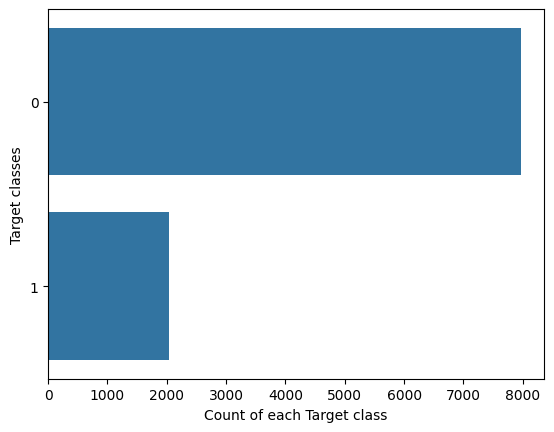

In [15]:
sns.countplot(y=churn_data_encoded.Exited ,data=churn_data_encoded)
plt.xlabel("Count of each Target class")
plt.ylabel("Target classes")
plt.show()

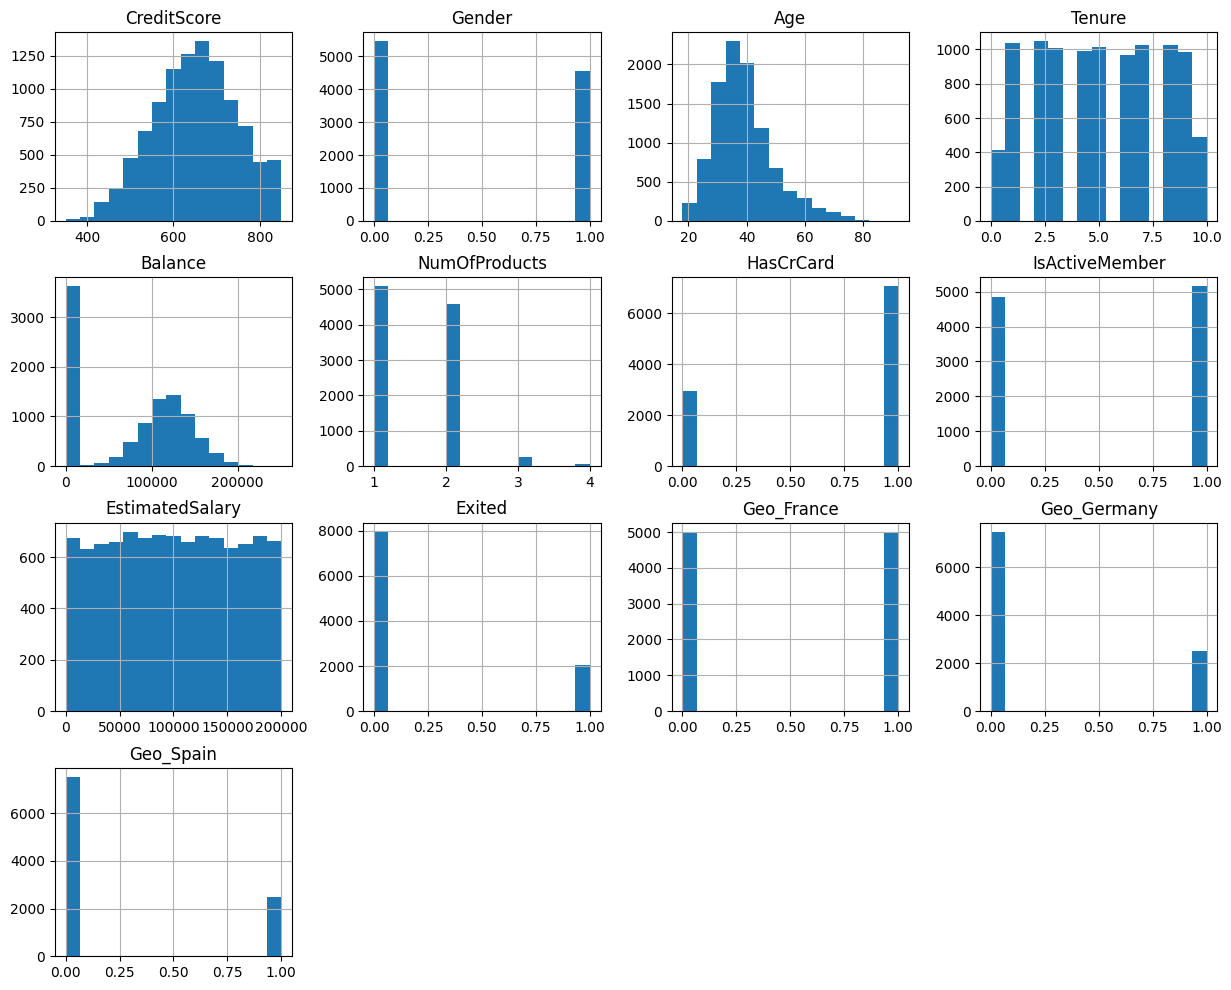

In [16]:
churn_data_encoded.hist(figsize=(15,12),bins = 15)
plt.title("Features Distribution")
plt.show()

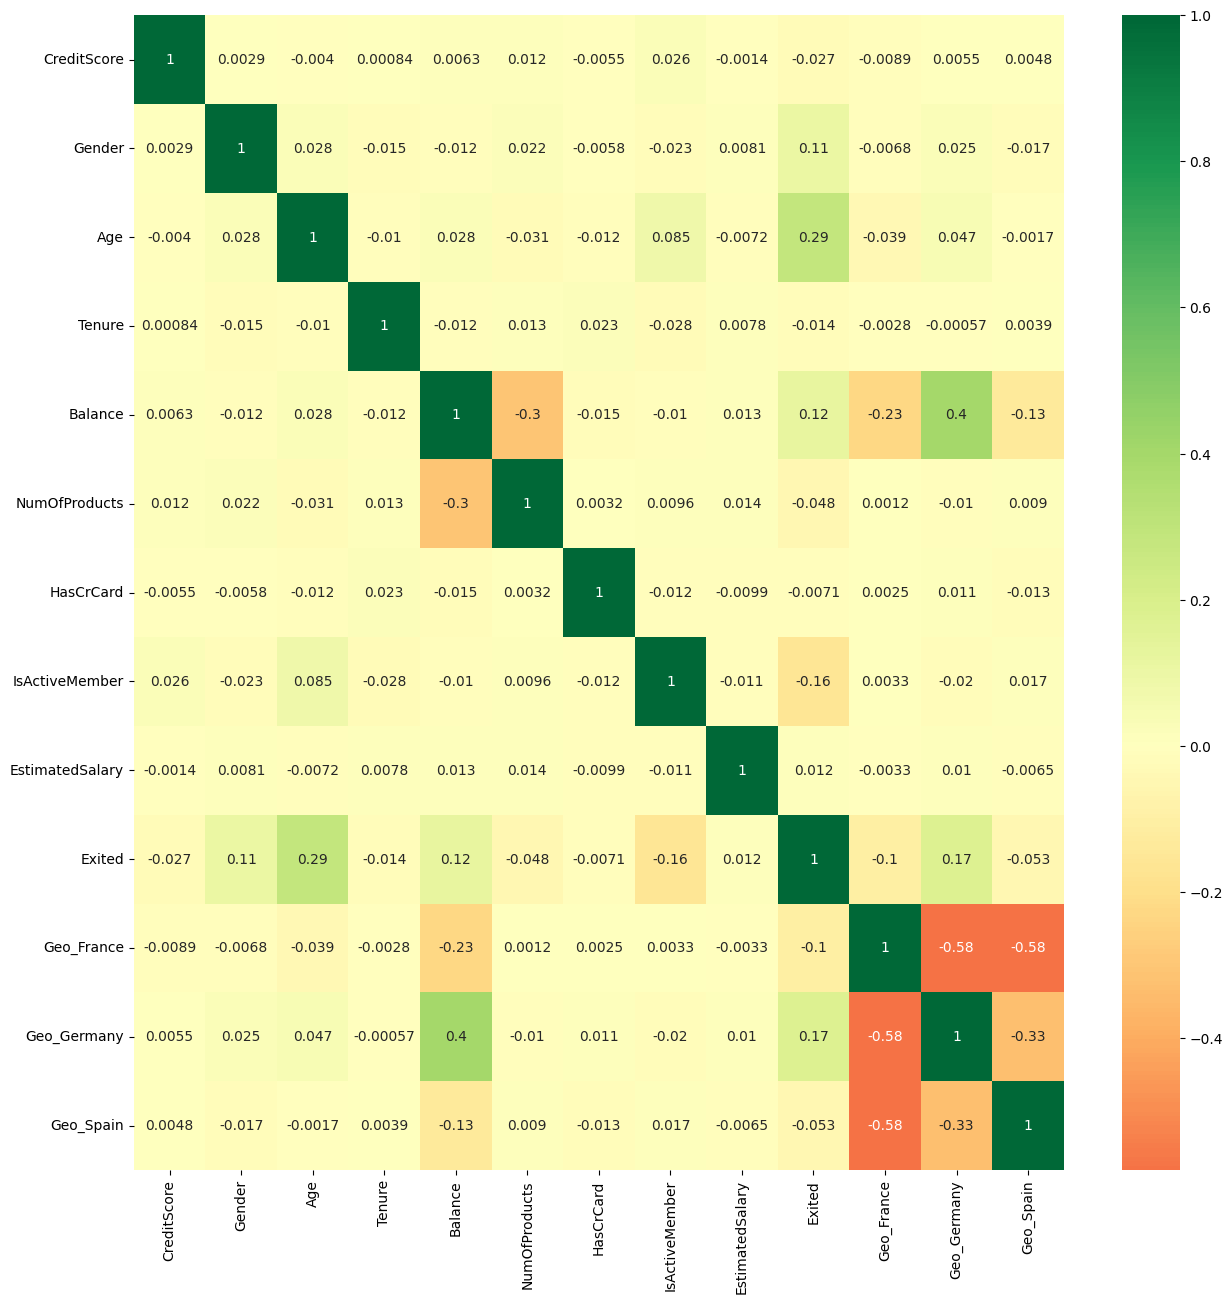

In [17]:
plt.figure(figsize=(15,15))
p=sns.heatmap(churn_data_encoded.corr(), annot=True,cmap='RdYlGn',center=0) 

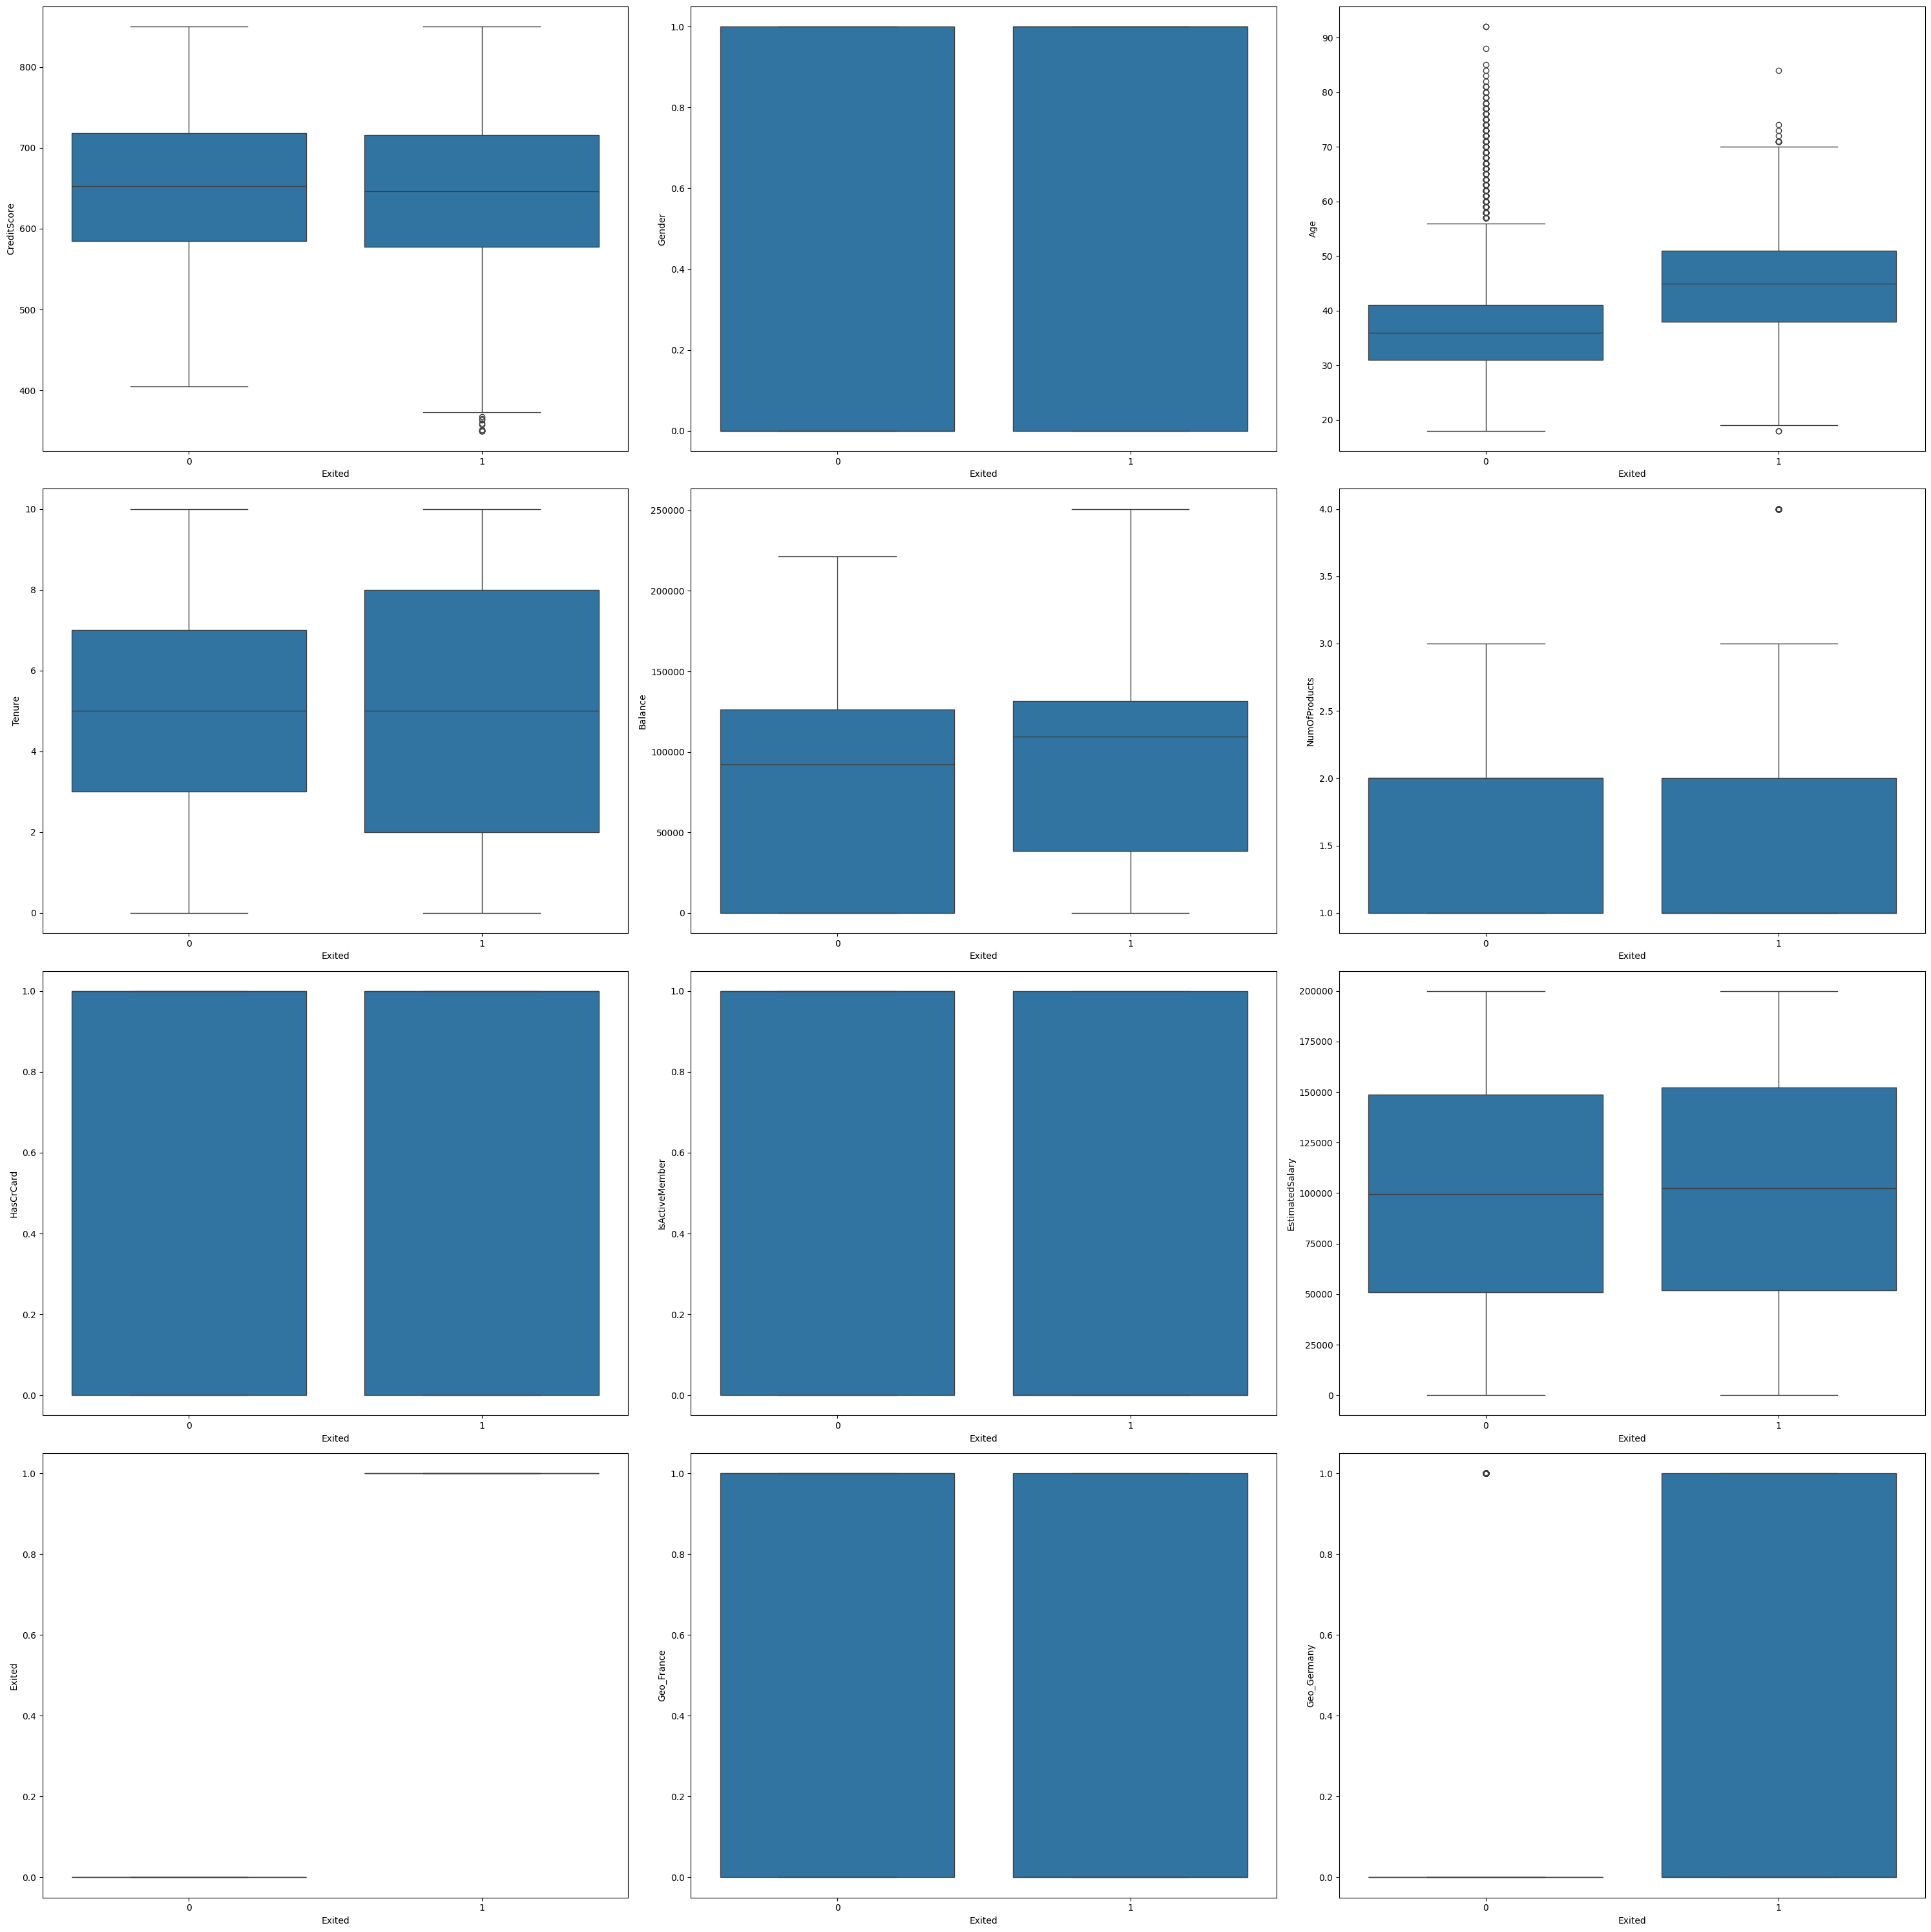

In [18]:
fig,ax = plt.subplots(nrows = 4, ncols=3, figsize=(30,30))
row = 0
col = 0
for i in range(len(churn_data_encoded.columns) -1):
    if col > 2:
        row += 1
        col = 0
    axes = ax[row,col]
    sns.boxplot(x = churn_data_encoded['Exited'], y = churn_data_encoded[churn_data_encoded.columns[i]],ax = axes)
    col += 1
plt.tight_layout()
# plt.title("Individual Features by Class")
plt.show()


In [19]:
X = churn_data_encoded.drop(['Exited'],axis=1)
y = churn_data_encoded.Exited

In [20]:
X.head(10)


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geo_France,Geo_Germany,Geo_Spain
RowNumber,,,,,,,,,,,,
1,619,1,42,2,0.00,1,1,1,101348.88,1,0,0
2,608,1,41,1,83807.86,1,0,1,112542.58,0,0,1
3,502,1,42,8,159660.80,3,1,0,113931.57,1,0,0
4,699,1,39,1,0.00,2,0,0,93826.63,1,0,0
5,850,1,43,2,125510.82,1,1,1,79084.10,0,0,1
6,645,0,44,8,113755.78,2,1,0,149756.71,0,0,1
7,822,0,50,7,0.00,2,1,1,10062.80,1,0,0
8,376,1,29,4,115046.74,4,1,0,119346.88,0,1,0
9,501,0,44,4,142051.07,2,0,1,74940.50,1,0,0


In [21]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [22]:
# Feature Scaling because yes we don't want one independent variable dominating the other and it makes computations easy
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [56]:
# sequential model to initialise our ann and dense module to build the layers
from keras.models import Sequential
from keras.layers import Dense

In [57]:
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))

# Adding the second hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN | means applying SGD on the whole ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100,verbose = 1)

Epoch 1/100
670/670 [==============================] - 2s 2ms/step - loss: 0.4979 - accuracy: 0.7919
Epoch 2/100
670/670 [==============================] - 1s 2ms/step - loss: 0.4358 - accuracy: 0.7919
Epoch 3/100
670/670 [==============================] - 1s 2ms/step - loss: 0.4310 - accuracy: 0.7919
Epoch 4/100
670/670 [==============================] - 1s 2ms/step - loss: 0.4265 - accuracy: 0.8064
Epoch 5/100
670/670 [==============================] - 1s 2ms/step - loss: 0.4234 - accuracy: 0.8216
Epoch 6/100
670/670 [==============================] - 1s 2ms/step - loss: 0.4214 - accuracy: 0.8254
Epoch 7/100
670/670 [==============================] - 1s 2ms/step - loss: 0.4195 - accuracy: 0.8269
Epoch 8/100
670/670 [==============================] - 1s 2ms/step - loss: 0.4177 - accuracy: 0.8273
Epoch 9/100
670/670 [==============================] - 1s 2ms/step - loss: 0.4154 - accuracy: 0.8296
Epoch 10/100
670/670 [==============================] - 1s 2ms/step - loss: 0.4122 - accura

670/670 [==============================] - 1s 2ms/step - loss: 0.3970 - accuracy: 0.8331
Epoch 82/100
670/670 [==============================] - 1s 2ms/step - loss: 0.3967 - accuracy: 0.8333
Epoch 83/100
670/670 [==============================] - 1s 2ms/step - loss: 0.3963 - accuracy: 0.8342
Epoch 84/100
670/670 [==============================] - 1s 2ms/step - loss: 0.3967 - accuracy: 0.8336
Epoch 85/100
670/670 [==============================] - 1s 2ms/step - loss: 0.3969 - accuracy: 0.8324
Epoch 86/100
670/670 [==============================] - 1s 2ms/step - loss: 0.3967 - accuracy: 0.8349
Epoch 87/100
670/670 [==============================] - 1s 2ms/step - loss: 0.3967 - accuracy: 0.8334
Epoch 88/100
670/670 [==============================] - 1s 2ms/step - loss: 0.3966 - accuracy: 0.8346
Epoch 89/100
670/670 [==============================] - 1s 2ms/step - loss: 0.3961 - accuracy: 0.8352
Epoch 90/100
670/670 [==============================] - 1s 2ms/step - loss: 0.3971 - accuracy: 

In [58]:
score, acc = classifier.evaluate(X_train, y_train,
                            batch_size=10)
print('Train score:', score)
print('Train accuracy:', acc)
# Part 3 - Making predictions and evaluating the model

# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

print('*'*20)
score, acc = classifier.evaluate(X_test, y_test,
                            batch_size=10)
print('Test score:', score)
print('Test accuracy:', acc)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

670/670 [==============================] - 1s 2ms/step - loss: 0.3940 - accuracy: 0.8360
Train score: 0.3939654529094696
Train accuracy: 0.8359701633453369
104/104 [==============================] - 0s 1ms/step
********************
330/330 [==============================] - 1s 2ms/step - loss: 0.3885 - accuracy: 0.8455
Test score: 0.3885442316532135
Test accuracy: 0.8454545736312866


### Evaluation Metrics

Text(0.5, 23.52222222222222, 'Predicted label')

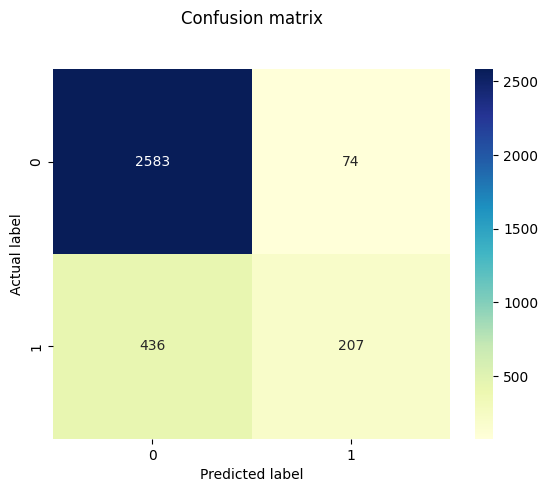

In [59]:
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [60]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      2657
           1       0.74      0.32      0.45       643

    accuracy                           0.85      3300
   macro avg       0.80      0.65      0.68      3300
weighted avg       0.83      0.85      0.82      3300



104/104 [==============================] - 0s 1ms/step


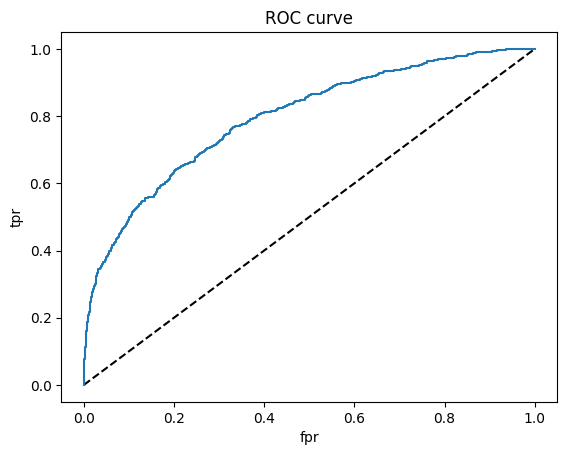

In [61]:
from sklearn.metrics import roc_curve
y_pred_proba = classifier.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [62]:
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.7949288566075352

## Evaluation of Multiple Training Instances

In [32]:
# Part 4 - Evaluating, Improving and Tuning the ANN

# Evaluating the ANN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense
def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 100,verbose=1)
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
mean = accuracies.mean()
variance = accuracies.std()

Epoch 1/100


C:\Users\sanjay\AppData\Local\Temp\ipykernel_30588\794858004.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 100,verbose=1)


603/603 [==============================] - 2s 2ms/step - loss: 0.5034 - accuracy: 0.7942
Epoch 2/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4335 - accuracy: 0.7954
Epoch 3/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4281 - accuracy: 0.7954
Epoch 4/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4245 - accuracy: 0.7954
Epoch 5/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4214 - accuracy: 0.8070
Epoch 6/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4191 - accuracy: 0.8255
Epoch 7/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4168 - accuracy: 0.8282
Epoch 8/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4146 - accuracy: 0.8292
Epoch 9/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4133 - accuracy: 0.8303
Epoch 10/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4117 - accuracy: 0.8299
E

603/603 [==============================] - 1s 2ms/step - loss: 0.3995 - accuracy: 0.8332
Epoch 82/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4003 - accuracy: 0.8343
Epoch 83/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3996 - accuracy: 0.8342
Epoch 84/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4001 - accuracy: 0.8312
Epoch 85/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3998 - accuracy: 0.8328
Epoch 86/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4001 - accuracy: 0.8317
Epoch 87/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3997 - accuracy: 0.8340
Epoch 88/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3996 - accuracy: 0.8338
Epoch 89/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3996 - accuracy: 0.8338
Epoch 90/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3997 - accuracy: 

603/603 [==============================] - 1s 2ms/step - loss: 0.3679 - accuracy: 0.8476
Epoch 61/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3675 - accuracy: 0.8463
Epoch 62/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3670 - accuracy: 0.8484
Epoch 63/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3663 - accuracy: 0.8491
Epoch 64/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3662 - accuracy: 0.8516
Epoch 65/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3656 - accuracy: 0.8476
Epoch 66/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3650 - accuracy: 0.8506
Epoch 67/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3651 - accuracy: 0.8511
Epoch 68/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3648 - accuracy: 0.8496
Epoch 69/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3645 - accuracy: 

603/603 [==============================] - 1s 2ms/step - loss: 0.3485 - accuracy: 0.8584
Epoch 40/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3483 - accuracy: 0.8582
Epoch 41/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3469 - accuracy: 0.8572
Epoch 42/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3471 - accuracy: 0.8579
Epoch 43/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3472 - accuracy: 0.8575
Epoch 44/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3468 - accuracy: 0.8561
Epoch 45/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3461 - accuracy: 0.8579
Epoch 46/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3462 - accuracy: 0.8609
Epoch 47/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3463 - accuracy: 0.8575
Epoch 48/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3457 - accuracy: 

603/603 [==============================] - 1s 2ms/step - loss: 0.4136 - accuracy: 0.8299
Epoch 19/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4130 - accuracy: 0.8280
Epoch 20/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4121 - accuracy: 0.8308
Epoch 21/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4122 - accuracy: 0.8297
Epoch 22/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4117 - accuracy: 0.8303
Epoch 23/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4114 - accuracy: 0.8299
Epoch 24/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4111 - accuracy: 0.8285
Epoch 25/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4105 - accuracy: 0.8303
Epoch 26/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4107 - accuracy: 0.8295
Epoch 27/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4105 - accuracy: 

603/603 [==============================] - 1s 2ms/step - loss: 0.4052 - accuracy: 0.8282
Epoch 99/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4055 - accuracy: 0.8297
Epoch 100/100
67/67 [==============================] - 0s 1ms/step - loss: 0.3964 - accuracy: 0.8403
Epoch 1/100
603/603 [==============================] - 2s 2ms/step - loss: 0.5104 - accuracy: 0.7887
Epoch 2/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4131 - accuracy: 0.8307
Epoch 3/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3854 - accuracy: 0.8421
Epoch 4/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3710 - accuracy: 0.8469
Epoch 5/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3642 - accuracy: 0.8524
Epoch 6/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3604 - accuracy: 0.8504
Epoch 7/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3586 - accuracy: 0.8546
E

603/603 [==============================] - 1s 2ms/step - loss: 0.3437 - accuracy: 0.8570
Epoch 78/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3427 - accuracy: 0.8587
Epoch 79/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3431 - accuracy: 0.8552
Epoch 80/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3430 - accuracy: 0.8552
Epoch 81/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3435 - accuracy: 0.8582
Epoch 82/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3428 - accuracy: 0.8567
Epoch 83/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3421 - accuracy: 0.8582
Epoch 84/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3425 - accuracy: 0.8587
Epoch 85/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3428 - accuracy: 0.8600
Epoch 86/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3428 - accuracy: 

603/603 [==============================] - 1s 2ms/step - loss: 0.3531 - accuracy: 0.8551
Epoch 57/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3518 - accuracy: 0.8532
Epoch 58/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3532 - accuracy: 0.8569
Epoch 59/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3528 - accuracy: 0.8514
Epoch 60/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3528 - accuracy: 0.8524
Epoch 61/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3523 - accuracy: 0.8536
Epoch 62/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3522 - accuracy: 0.8546
Epoch 63/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3522 - accuracy: 0.8509
Epoch 64/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3524 - accuracy: 0.8527
Epoch 65/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3520 - accuracy: 

603/603 [==============================] - 1s 2ms/step - loss: 0.4043 - accuracy: 0.8342
Epoch 36/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4041 - accuracy: 0.8305
Epoch 37/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4040 - accuracy: 0.8335
Epoch 38/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4042 - accuracy: 0.8340
Epoch 39/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4044 - accuracy: 0.8318
Epoch 40/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4041 - accuracy: 0.8328
Epoch 41/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4031 - accuracy: 0.8330
Epoch 42/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4043 - accuracy: 0.8315
Epoch 43/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4030 - accuracy: 0.8330
Epoch 44/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4034 - accuracy: 

603/603 [==============================] - 1s 2ms/step - loss: 0.4110 - accuracy: 0.8289
Epoch 15/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4104 - accuracy: 0.8295
Epoch 16/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4097 - accuracy: 0.8313
Epoch 17/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4094 - accuracy: 0.8280
Epoch 18/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4089 - accuracy: 0.8299
Epoch 19/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4084 - accuracy: 0.8313
Epoch 20/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4087 - accuracy: 0.8294
Epoch 21/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4079 - accuracy: 0.8313
Epoch 22/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4072 - accuracy: 0.8297
Epoch 23/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4073 - accuracy: 

603/603 [==============================] - 1s 2ms/step - loss: 0.3644 - accuracy: 0.8479
Epoch 95/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3565 - accuracy: 0.8544
Epoch 96/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3512 - accuracy: 0.8556
Epoch 97/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3478 - accuracy: 0.8592
Epoch 98/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3470 - accuracy: 0.8572
Epoch 99/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3451 - accuracy: 0.8590
Epoch 100/100
67/67 [==============================] - 0s 2ms/step - loss: 0.3568 - accuracy: 0.8522
Epoch 1/100
603/603 [==============================] - 2s 2ms/step - loss: 0.5231 - accuracy: 0.7894
Epoch 2/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4294 - accuracy: 0.8100
Epoch 3/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4147 - accuracy: 0.82

603/603 [==============================] - 1s 2ms/step - loss: 0.3441 - accuracy: 0.8567
Epoch 74/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3432 - accuracy: 0.8579
Epoch 75/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3434 - accuracy: 0.8577
Epoch 76/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3431 - accuracy: 0.8610
Epoch 77/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3444 - accuracy: 0.8554
Epoch 78/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3437 - accuracy: 0.8579
Epoch 79/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3432 - accuracy: 0.8602
Epoch 80/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3426 - accuracy: 0.8579
Epoch 81/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3433 - accuracy: 0.8585
Epoch 82/100
603/603 [==============================] - 1s 2ms/step - loss: 0.3434 - accuracy: 

603/603 [==============================] - 1s 2ms/step - loss: 0.4075 - accuracy: 0.8297
Epoch 53/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4071 - accuracy: 0.8315
Epoch 54/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4066 - accuracy: 0.8322
Epoch 55/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4074 - accuracy: 0.8313
Epoch 56/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4072 - accuracy: 0.8332
Epoch 57/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4067 - accuracy: 0.8318
Epoch 58/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4068 - accuracy: 0.8310
Epoch 59/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4066 - accuracy: 0.8320
Epoch 60/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4067 - accuracy: 0.8315
Epoch 61/100
603/603 [==============================] - 1s 2ms/step - loss: 0.4073 - accuracy: 

In [33]:
print('Mean accuracy score of 10 different models using Kfold cross validation: {}'.format(mean))
print('Standard Deviation of accuracy score of 10 different models using Kfold cross validation: {}'.format(variance))

Mean accuracy score of 10 different models using Kfold cross validation: 0.8426865696907043
Standard Deviation of accuracy score of 10 different models using Kfold cross validation: 0.026842443417778798


## Improving ANN with Dropout layer

Dropout Regularization is used to reduce overfitting if needed.
p is the fraction of input units to drop. If suppose there are ten neurons from a layer and p is 0.1 then one of the neurons would be disabled and its output would not be sent to the further layer.
It is advisable to start with p 0.1 and move to higher values when in case the overfitting problem persists. Also going over 0.5 is not advisable generally because it may cause underfitting as most of the neurons are disabled.

In [34]:
# Improving the ANN
from keras.layers import Dropout
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))
classifier.add(Dropout(rate = 0.1))

# Adding the second hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(rate = 0.1))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100,verbose = 0)

In [35]:
# Part 3 - Making predictions and evaluating the model

score, acc = classifier.evaluate(X_train, y_train,
                            batch_size=10)
print('Train score:', score)
print('Train accuracy:', acc)
# Part 3 - Making predictions and evaluating the model

# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

print('*'*20)
score, acc = classifier.evaluate(X_test, y_test,
                            batch_size=10)
print('Test score:', score)
print('Test accuracy:', acc)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

670/670 [==============================] - 1s 2ms/step - loss: 0.4127 - accuracy: 0.8318
Train score: 0.41270577907562256
Train accuracy: 0.8317910432815552
104/104 [==============================] - 0s 1ms/step
********************
330/330 [==============================] - 1s 2ms/step - loss: 0.3984 - accuracy: 0.8430
Test score: 0.39835938811302185
Test accuracy: 0.8430302739143372


Text(0.5, 23.52222222222222, 'Predicted label')

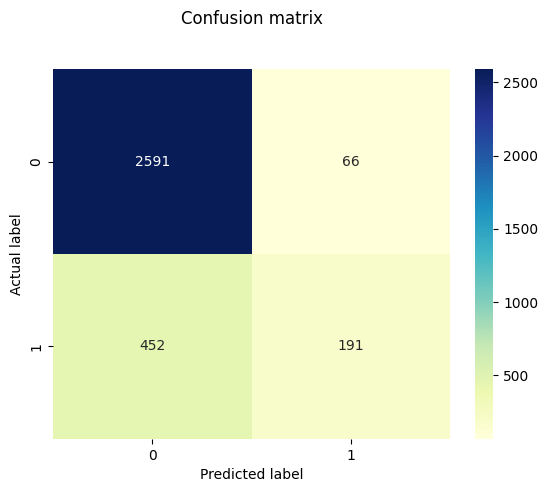

In [36]:
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [37]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      2657
           1       0.74      0.30      0.42       643

    accuracy                           0.84      3300
   macro avg       0.80      0.64      0.67      3300
weighted avg       0.83      0.84      0.81      3300



104/104 [==============================] - 0s 1ms/step


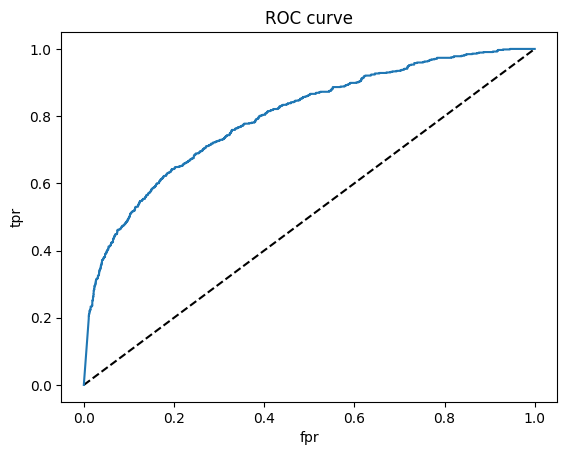

In [44]:
from sklearn.metrics import roc_curve
y_pred_proba = classifier.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [45]:
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.7967021003236265

In [ ]:
# Tuning the ANN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [25, 32],
              'epochs': [100, 200],
              'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5)
grid_search = grid_search.fit(X_train, y_train,verbose = 0)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

C:\Users\sanjay\AppData\Local\Temp\ipykernel_30588\3680966899.py:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier)


42/42 [==============================] - 0s 927us/step


In [ ]:
print('Best Parameters after tuning: {}'.format(best_parameters))
print('Best Accuracy after tuning: {}'.format(best_accuracy))

## Decision Tree



In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

model = DecisionTreeClassifier() 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Training Accuracy :", model.score(X_train, y_train))
print("Testing Accuaracy :", model.score(X_test, y_test))

cm = confusion_matrix(y_test, y_pred)
print(cm)

Training Accuracy : 1.0
Testing Accuaracy : 0.7848484848484848
[[2271  386]
 [ 324  319]]


## Random Forest



In [43]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Training Accuracy :", model.score(X_train, y_train))
print("Testing Accuracy :", model.score(X_test, y_test))

cm = confusion_matrix(y_test, y_pred)
print(cm)

Training Accuracy : 1.0
Testing Accuracy : 0.87
[[2567   90]
 [ 339  304]]


In [48]:
# k fold cross validatio

from sklearn.model_selection import cross_val_score

cvs = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
print(cvs)

[0.85373134 0.87014925 0.85820896 0.86119403 0.86119403 0.86268657
 0.84925373 0.85373134 0.85820896 0.85522388]


In [49]:
print("Mean Accuracy :", cvs.mean())
print("Variance :", cvs.std())

Mean Accuracy : 0.858358208955224
Variance : 0.005562580642860953


## Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Training Accuracy :", model.score(X_train, y_train))
print("Testing Accuracy :", model.score(X_test, y_test))

cm = confusion_matrix(y_test, y_pred)
print(cm)

Training Accuracy : 0.8097014925373134
Testing Accuracy : 0.8115151515151515
[[2545  112]
 [ 510  133]]


## Support Vector Machine



In [51]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Training Accuracy :", model.score(X_train, y_train))
print("Testing Accuracy :", model.score(X_test, y_test))

cm = confusion_matrix(y_test, y_pred)
print(cm)

Training Accuracy : 0.8622388059701492
Testing Accuracy : 0.8606060606060606
[[2590   67]
 [ 393  250]]


In [53]:
# k fold cross validatio

from sklearn.model_selection import cross_val_score

cvs = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
print(cvs)

[0.83731343 0.85522388 0.83134328 0.85970149 0.86119403 0.86268657
 0.84925373 0.85373134 0.84925373 0.84328358]


In [54]:
print("Mean Accuracy :", cvs.mean())
print("Variance :", cvs.std())

Mean Accuracy : 0.8502985074626868
Variance : 0.009878973578133079


## Multi Layer Perceptron



In [55]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes = (100, 100), activation ='relu', 
                      solver = 'adam', max_iter = 50)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Training Accuracy :", model.score(X_train, y_train))
print("Testing Accuracy :", model.score(X_test, y_test))

cm = confusion_matrix(y_test, y_pred)
print(cm)
     

Training Accuracy : 0.8807462686567165
Testing Accuracy : 0.866969696969697
[[2561   96]
 [ 343  300]]


C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
